### Movie Recommendation System

## **Dataset**
The data used in this project is retrieved from the `MovieLens Datasets`. The MovieLens dataset is a stable benchmark dataset that contains 25 million movie ratings and one million tag applications applied to 62,000 movies by 162,000 users. The dataset is available in a zip folder containing six CSV files:
* `genome-scores.csv`
* `genome-tags.csv`
* `links.csv`
* `movies.csv`
* `ratings.csv`
* `tags.csv`

For our model, we will primarily use the `movies.csv` and `ratings.csv` files.


## **Getting the Workspace Ready**

In [1]:
#Installing tensroflow into the notebook environment
!pip install tensorflow

In [2]:
!pip install keras

In [3]:
%pip install IPython

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from IPython.core.interactiveshell import InteractiveShell

from tensorflow.keras.layers import Input, Dot, Reshape, Dense, Add, Activation, Lambda, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from keras.callbacks import ModelCheckpoint

%matplotlib inline
%time

Wall time: 0 ns


## **Getting Data Ready**

Loading the csv files needed for our recommendation model system.

In [5]:
rating_df = pd.read_csv("C:/Users/svijayaraghavan/Downloads/ml-25m/ml-25m/ratings.csv").loc[:,["userId","movieId","rating"]]
rating_df.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 572.2 MB


In [7]:
movie_df = pd.read_csv("C:/Users/svijayaraghavan/Downloads/ml-25m/ml-25m/movies.csv")
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [8]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


## **Accessing the Data**

In [9]:
#Checking if there are missing values in the loaded datasets
rating_df.isna().sum()


userId     0
movieId    0
rating     0
dtype: int64

In [10]:
movie_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

Meaning there's no missing data on both of the datasets, we proceed with the next steps

In [11]:
n_users = len(rating_df.userId.unique())
n_movies = len(rating_df.movieId.unique())
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies, "\n")

No of unique users: 162541
No of unique movies:  59047 



In [12]:
rating_count = rating_df[['movieId','rating']].groupby(['movieId']).count()
rating_count

,rating
movieId,
1,57309
2,24228
3,11804
4,2523
5,11714
...,...
209157,1
209159,1
209163,1


<Figure size 1400x800 with 0 Axes>

C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_28616\1276343579.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='genres', data=ratings_with_genres, palette='Oranges')


<Axes: xlabel='rating', ylabel='genres'>

Text(0.5, 1.0, 'Box Plot of Ratings by Genre')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Genre')

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6')])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Comedy'),
  Text(0, 1, 'Crime'),
  Text(0, 2, 'Drama'),
  Text(0, 3, 'Thriller'),
  Text(0, 4, 'War'),
  Text(0, 5, 'Musical'),
  Text(0, 6, 'Romance'),
  Text(0, 7, 'Adventure'),
  Text(0, 8, 'Film-Noir'),
  Text(0, 9, 'Sci-Fi'),
  Text(0, 10, 'Western'),
  Text(0, 11, 'Fantasy'),
  Text(0, 12, 'Mystery'),
  Text(0, 13, 'Children'),
  Text(0, 14, 'Action'),
  Text(0, 15, 'Documentary'),
  Text(0, 16, 'Animation'),
  Text(0, 17, 'Horror'),
  Text(0, 18, 'IMAX'),
  Text(0, 19, '(no genres listed)')])

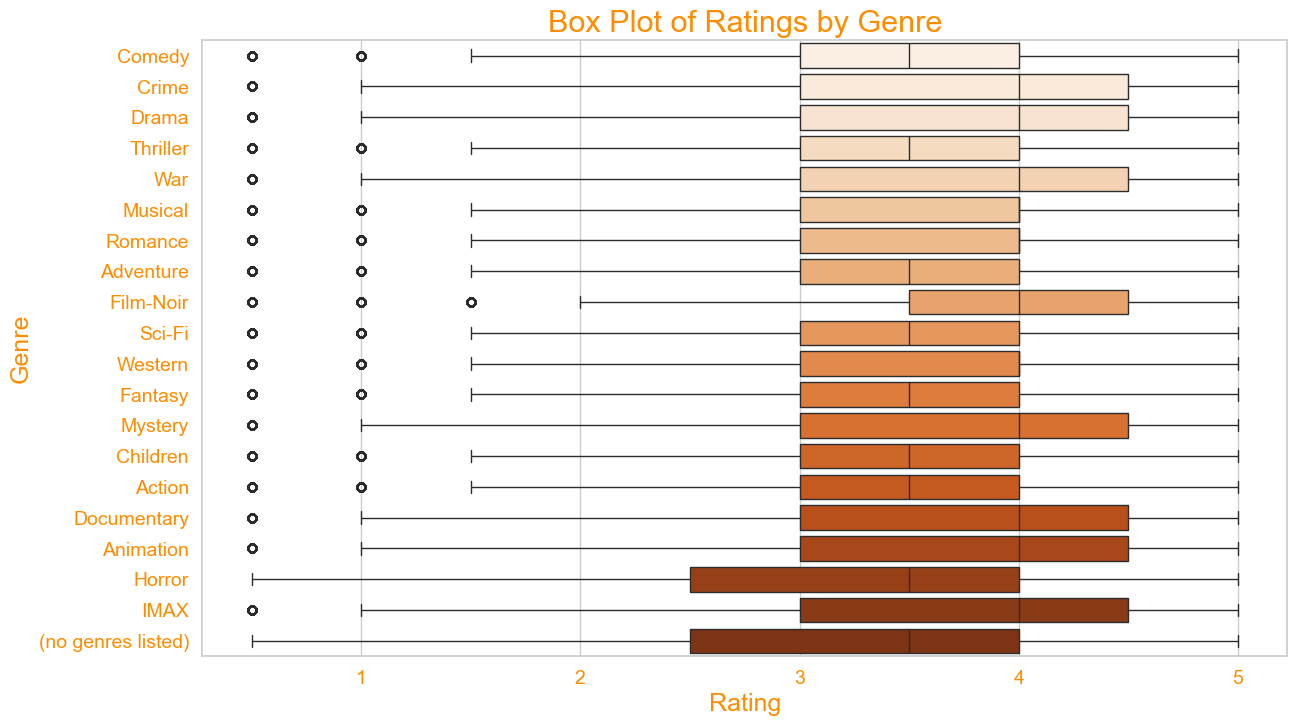

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Merge ratings with genres
ratings_with_genres = rating_df.merge(movie_df[['movieId', 'genres']], on='movieId')
ratings_with_genres['genres'] = ratings_with_genres['genres'].str.split('|')
ratings_with_genres = ratings_with_genres.explode('genres')

# Set figure size
plt.figure(figsize=(14, 8))

# Create the box plot with orange color
sns.boxplot(x='rating', y='genres', data=ratings_with_genres, palette='Oranges')

# Adding title and labels with larger font sizes
plt.title('Box Plot of Ratings by Genre', fontsize=22, color='darkorange')
plt.xlabel('Rating', fontsize=18, color='darkorange')
plt.ylabel('Genre', fontsize=18, color='darkorange')

# Customize the ticks
plt.xticks(fontsize=14, color='darkorange')
plt.yticks(fontsize=14, color='darkorange')

# Display the plot
plt.show()


<Figure size 1200x800 with 0 Axes>

<Axes: ylabel='genres'>

Text(0.5, 1.0, 'Distribution of Movies by Genre')

Text(0.5, 0, 'Number of Movies')

Text(0, 0.5, 'Genre')

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 [Text(0.0, 0, '0'),
  Text(5000.0, 0, '5000'),
  Text(10000.0, 0, '10000'),
  Text(15000.0, 0, '15000'),
  Text(20000.0, 0, '20000'),
  Text(25000.0, 0, '25000'),
  Text(30000.0, 0, '30000')])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(0, 1, 'Comedy'),
  Text(0, 2, 'Thriller'),
  Text(0, 3, 'Romance'),
  Text(0, 4, 'Action'),
  Text(0, 5, 'Horror'),
  Text(0, 6, 'Documentary'),
  Text(0, 7, 'Crime'),
  Text(0, 8, '(no genres listed)'),
  Text(0, 9, 'Adventure'),
  Text(0, 10, 'Sci-Fi'),
  Text(0, 11, 'Children'),
  Text(0, 12, 'Animation'),
  Text(0, 13, 'Mystery'),
  Text(0, 14, 'Fantasy'),
  Text(0, 15, 'War'),
  Text(0, 16, 'Western'),
  Text(0, 17, 'Musical'),
  Text(0, 18, 'Film-Noir'),
  Text(0, 19, 'IMAX')])

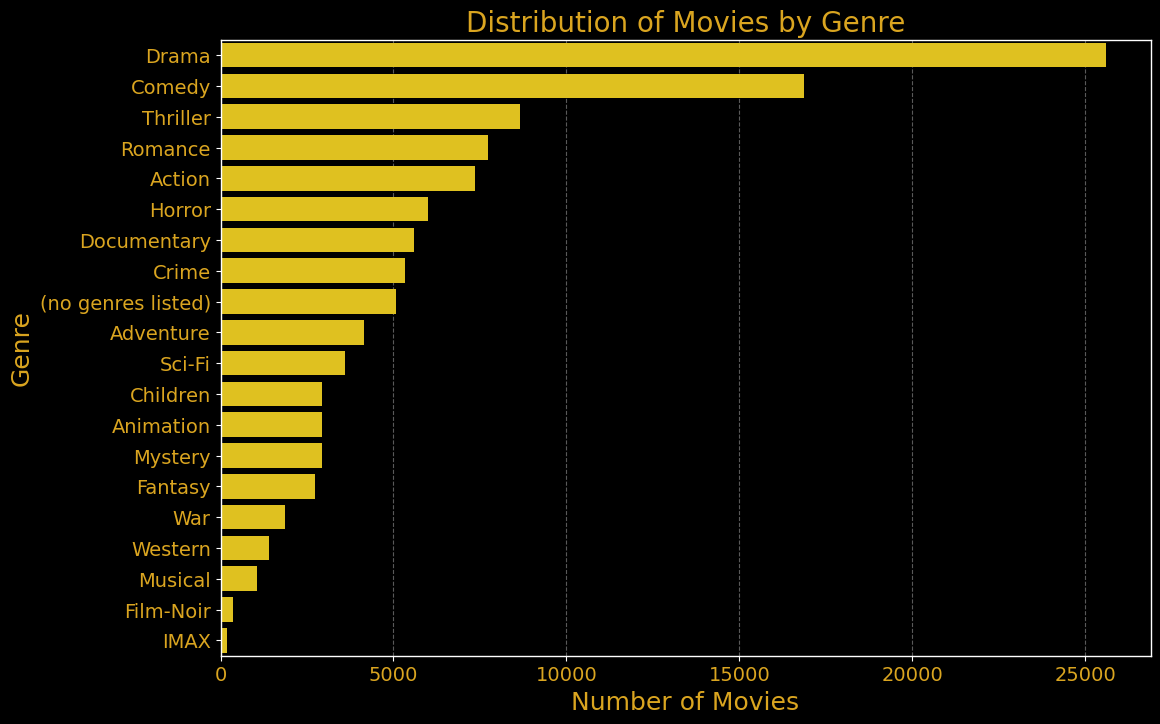

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Split genres and explode the dataframe
genre_df = movie_df.copy()
genre_df['genres'] = genre_df['genres'].str.split('|')
genre_df = genre_df.explode('genres')

# Count the number of movies per genre
genre_counts = genre_df['genres'].value_counts()

# Set figure size
plt.figure(figsize=(12, 8))

# Create the bar plot with golden yellow color
sns.barplot(x=genre_counts.values, y=genre_counts.index, color='gold')

# Adding title and labels with larger font sizes and golden yellow colors
plt.title('Distribution of Movies by Genre', fontsize=20, color='goldenrod')
plt.xlabel('Number of Movies', fontsize=18, color='goldenrod')
plt.ylabel('Genre', fontsize=18, color='goldenrod')
plt.xticks(fontsize=14, color='goldenrod')
plt.yticks(fontsize=14, color='goldenrod')

# Adding grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7, color='gray')

# Display the plot
plt.show()



<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='rating', ylabel='Count'>

Text(0.5, 1.0, 'Average Rating per Movie')

Text(0.5, 0, 'Average Rating')

Text(0, 0.5, 'Count')

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6')])

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000')])

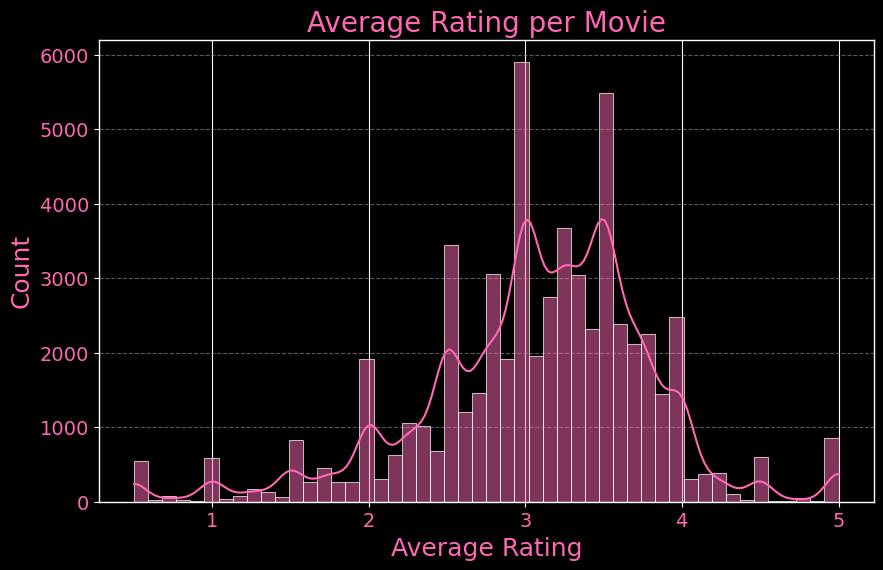

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average rating per movie
average_rating_per_movie = rating_df.groupby('movieId')['rating'].mean()

# Set figure size
plt.figure(figsize=(10, 6))

# Create the histogram with neon pink color
sns.histplot(average_rating_per_movie, bins=50, kde=True, color='hotpink')

# Adding title and labels with larger font sizes and bright colors
plt.title('Average Rating per Movie', fontsize=20, color='hotpink')
plt.xlabel('Average Rating', fontsize=18, color='hotpink')
plt.ylabel('Count', fontsize=18, color='hotpink')
plt.xticks(fontsize=14, color='hotpink')
plt.yticks(fontsize=14, color='hotpink')

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')

# Display the plot
plt.show()



<Figure size 1400x800 with 0 Axes>

C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_28616\1371434886.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_count', y=top_10_movie_titles['title'], data=top_10_movie_titles, palette=neon_palette)


<Axes: xlabel='rating_count', ylabel='title'>

Text(0.5, 1.0, 'Top 10 Movies by Number of Ratings')

Text(0.5, 0, 'Number of Ratings')

Text(0, 0.5, 'Movie Title')

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000., 90000.]),
 [Text(0.0, 0, '0'),
  Text(10000.0, 0, '10000'),
  Text(20000.0, 0, '20000'),
  Text(30000.0, 0, '30000'),
  Text(40000.0, 0, '40000'),
  Text(50000.0, 0, '50000'),
  Text(60000.0, 0, '60000'),
  Text(70000.0, 0, '70000'),
  Text(80000.0, 0, '80000'),
  Text(90000.0, 0, '90000')])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Forrest Gump (1994)'),
  Text(0, 1, 'Shawshank Redemption, The (1994)'),
  Text(0, 2, 'Pulp Fiction (1994)'),
  Text(0, 3, 'Silence of the Lambs, The (1991)'),
  Text(0, 4, 'Matrix, The (1999)'),
  Text(0, 5, 'Star Wars: Episode IV - A New Hope (1977)'),
  Text(0, 6, 'Jurassic Park (1993)'),
  Text(0, 7, "Schindler's List (1993)"),
  Text(0, 8, 'Braveheart (1995)'),
  Text(0, 9, 'Fight Club (1999)')])

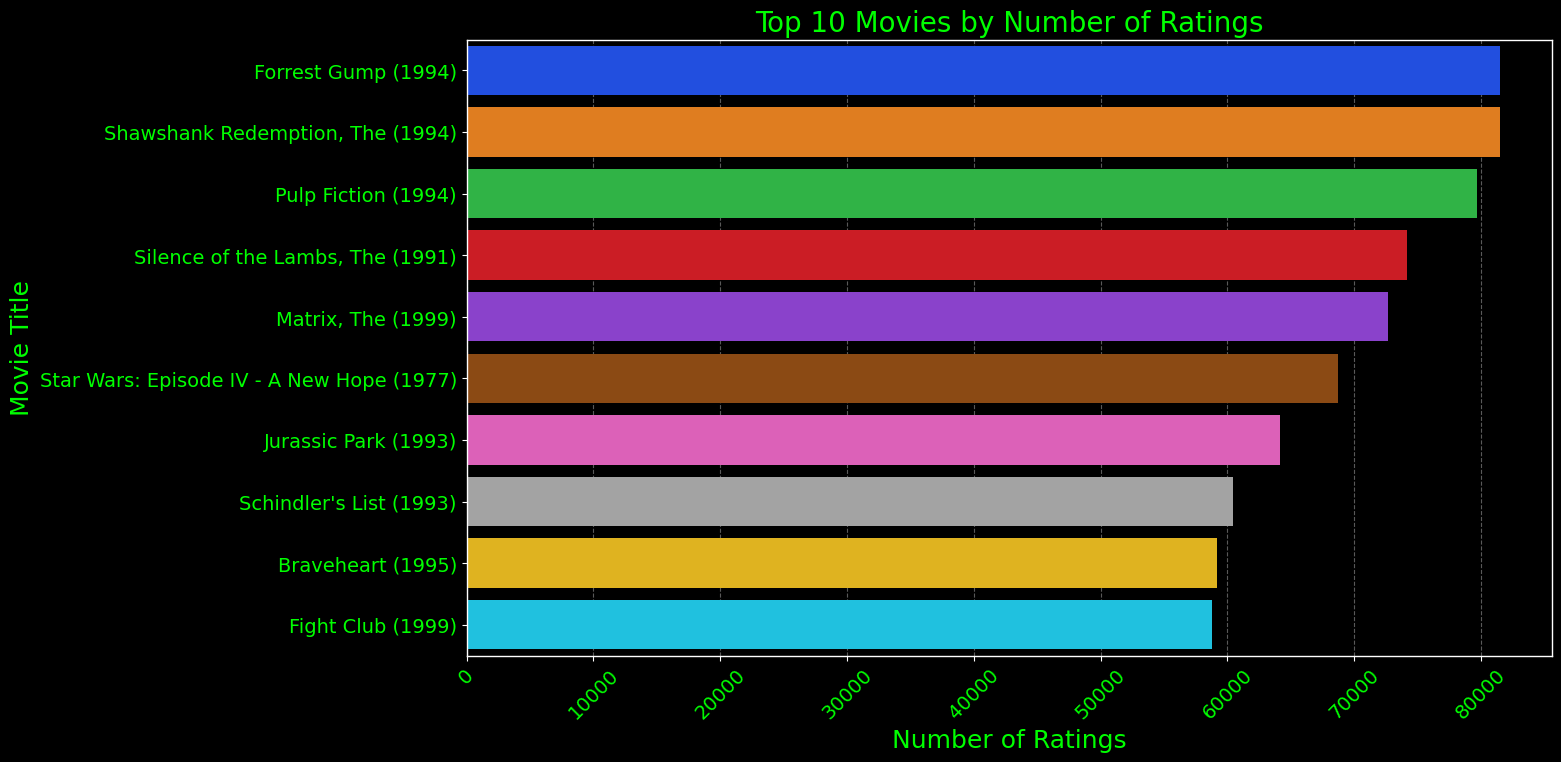

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of ratings per movie
ratings_per_movie = rating_df.groupby('movieId').size().sort_values(ascending=False)

# Get the top 10 movies by number of ratings
top_10_movies = ratings_per_movie.head(10).index
top_10_movie_titles = movie_df[movie_df['movieId'].isin(top_10_movies)]

# Merge with the ratings count
top_10_movie_titles = top_10_movie_titles.set_index('movieId').join(ratings_per_movie.rename('rating_count'))

# Sort the DataFrame by rating count in descending order
top_10_movie_titles = top_10_movie_titles.sort_values(by='rating_count', ascending=False)

# Set the dark theme
plt.style.use('dark_background')

# Set figure size
plt.figure(figsize=(14, 8))

# Use a neon color palette
neon_palette = sns.color_palette("bright", 10)

# Create the bar plot
sns.barplot(x='rating_count', y=top_10_movie_titles['title'], data=top_10_movie_titles, palette=neon_palette)

# Adding title and labels with larger font sizes and bright colors
plt.title('Top 10 Movies by Number of Ratings', fontsize=20, color='lime')
plt.xlabel('Number of Ratings', fontsize=18, color='lime')
plt.ylabel('Movie Title', fontsize=18, color='lime')
plt.xticks(rotation=45, fontsize=14, color='lime')
plt.yticks(fontsize=14, color='lime')

# Adding grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7, color='gray')

# Display the plot
plt.show()



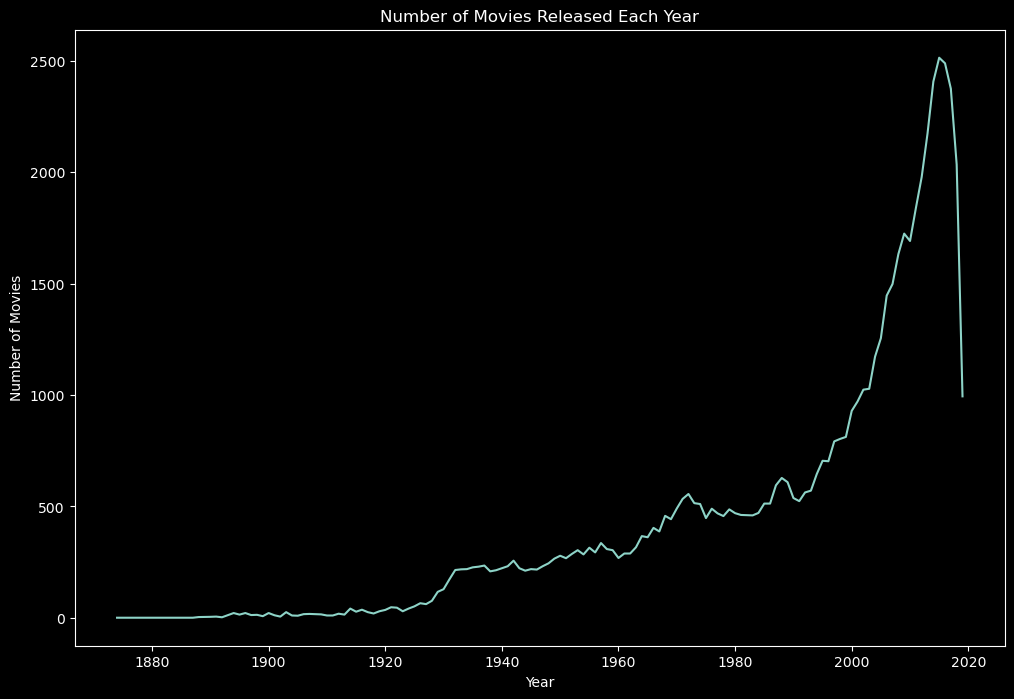

In [18]:
# Number of Movies Released Each Year
import re

# Extract year from the title
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Count the number of movies released each year
movies_per_year = movie_df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 8))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)
plt.title('Number of Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()


<Figure size 2000x1000 with 0 Axes>

(0.0, 209171.0)

(0.0, 85565.5)

Text(0.5, 1.0, 'Rating Number of Movies')

Text(0.5, 0, 'Movie ID')

Text(0, 0.5, 'Ratings for the Movies')

(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000., 225000.]),
 [Text(0.0, 0, '0'),
  Text(25000.0, 0, '25000'),
  Text(50000.0, 0, '50000'),
  Text(75000.0, 0, '75000'),
  Text(100000.0, 0, '100000'),
  Text(125000.0, 0, '125000'),
  Text(150000.0, 0, '150000'),
  Text(175000.0, 0, '175000'),
  Text(200000.0, 0, '200000'),
  Text(225000.0, 0, '225000')])

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000., 90000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000'),
  Text(0, 70000.0, '70000'),
  Text(0, 80000.0, '80000'),
  Text(0, 90000.0, '90000')])

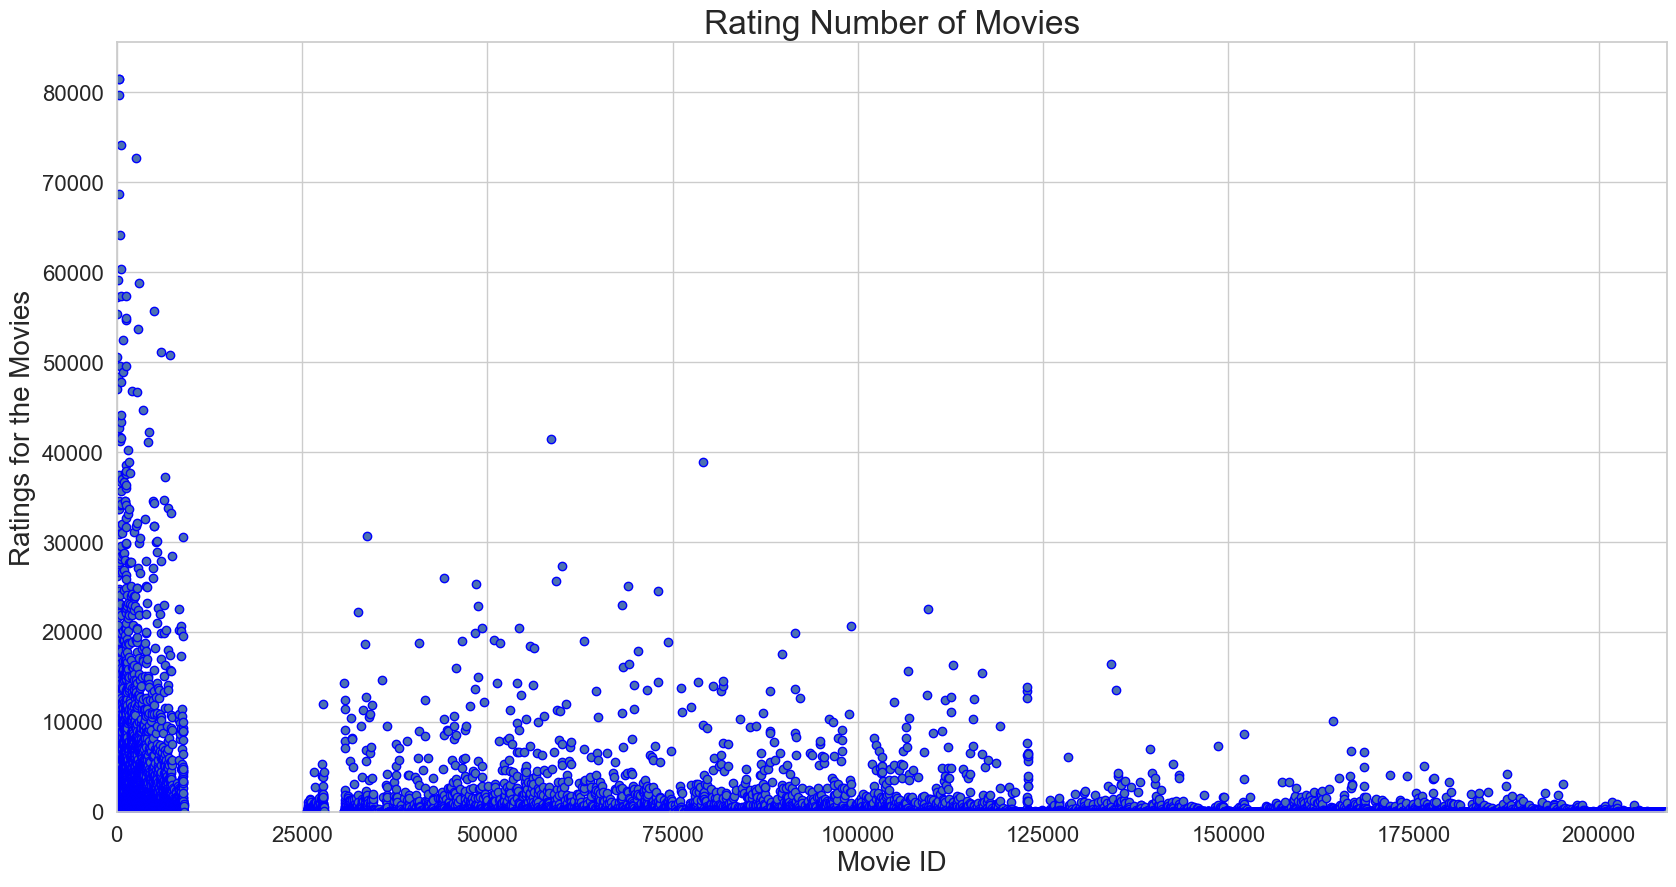

In [73]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(20, 10))

# Create the scatter plot
plt.scatter(rating_count.index, rating_count.rating, edgecolor='blue')

# Set the limits for x and y axes
plt.xlim(0, rating_count.index.max())
plt.ylim(0,)

# Adding title and labels with larger font sizes
plt.title('Rating Number of Movies', fontsize=24)
plt.xlabel('Movie ID', fontsize=20)
plt.ylabel('Ratings for the Movies', fontsize=20)

# Customize the ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Display the plot
plt.show()


_Therefore we'll be using only the movies that have recieved more than 5,000 ratings. So as to provide recommendations to popular movies._

In [21]:
top_movies = rating_df[rating_df.groupby('movieId')['rating'].transform('size')>3000]
top_movies

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
4,1,899,3.5
5,1,1088,4.0
...,...,...,...
25000088,162541,41566,4.0
25000089,162541,45517,4.5
25000090,162541,50872,4.5
25000093,162541,58559,4.0


In [22]:
# Merging ratings and movies databases to get a single dataframe
data = pd.merge(movie_df,top_movies)
data

,movieId,title,genres,year,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,8,4.0
...,...,...,...,...,...,...
18729068,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162271,3.0
18729069,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162307,5.0
18729070,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162335,5.0
18729071,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162366,5.0


_Observing the new dataset features_

In [23]:
n_users = len(data.userId.unique())
n_movies = len(data.movieId.unique())
min_rating = min(data['rating'])
max_rating = max(data['rating'])
print("No of unique users:", n_users)
print("No of unique movies: ", n_movies)
print("Minimum Rating: ", min_rating)
print("Maximum Rating:", max_rating)

No of unique users: 162529
No of unique movies:  1830
Minimum Rating:  0.5
Maximum Rating: 5.0


_Observing the frequency of the rating value in the new dataset ranging from 0.5 - 5_

<Figure size 800x400 with 0 Axes>

<Axes: ylabel='Frequency'>

Text(0.5, 1.0, 'Distribution of Ratings')

Text(0.5, 0, 'Ratings')

Text(0, 0.5, 'Frequency')

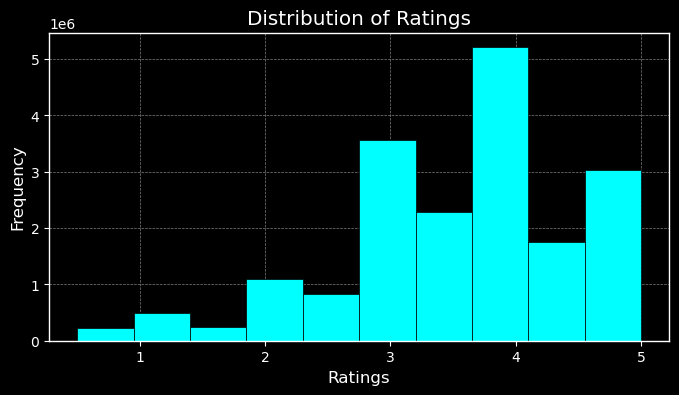

In [65]:
import matplotlib.pyplot as plt

# Set dark theme
plt.style.use('dark_background')

# Set figure size (width, height) in inches
plt.figure(figsize=(8, 4))

# Plotting a histogram
data['rating'].plot(kind='hist', bins=10, color='cyan', edgecolor='black')

# Adding title and labels
plt.title('Distribution of Ratings', color='white')
plt.xlabel('Ratings', color='white')
plt.ylabel('Frequency', color='white')

# Adding grid lines
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()


_Observing that the userIds and the movieIds are not continuous in the dataset, hence using Scikit-Learn's LabelEncoder to assign unique sequential IDs starting at zero._

In [25]:
LE_user = LabelEncoder()
LE_movie = LabelEncoder()
# LE_genres = LabelEncoder()
data['UniqueUserId'] = LE_user.fit_transform(data['userId'].values)
data['UniqueMovieId'] = LE_movie.fit_transform(data['movieId'].values)
# data['genres_encoded'] = LE_genres.fit_transform(data['genres'])
data

,movieId,title,genres,year,userId,rating,UniqueUserId,UniqueMovieId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,2,3.5,1,0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,3,4.0,2,0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,4,3.0,3,0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,5,4.0,4,0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,8,4.0,7,0
...,...,...,...,...,...,...,...,...
18729068,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162271,3.0,162258,1829
18729069,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162307,5.0,162294,1829
18729070,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162335,5.0,162322,1829
18729071,195159,Spider-Man: Into the Spider-Verse (2018),Action|Adventure|Animation|Sci-Fi,2018.0,162366,5.0,162353,1829


## **Creating Our Own Validation Set**

We will now create our ( [userId, movieId] , rating) pairing of data and label that will be input into our model for training. We will not be using a testing or a validation dataset, as our end objective is not to make accurate predictions on new data, but learn the best entitiy embeddings.

In [26]:
X = data[['UniqueUserId', 'UniqueMovieId']].values
y = data['rating'].values
X_array = [X[:,0], X[:, 1]]
print('Input (X_combined):', X_array, '\n')
print('Output (Rating): ', y, '\n')

Input (X_combined): [array([     1,      2,      3, ..., 162322, 162353, 162503], dtype=int64), array([   0,    0,    0, ..., 1829, 1829, 1829], dtype=int64)] 

Output (Rating):  [3.5 4.  3.  ... 5.  5.  3.5] 



## **Building the model**

In [27]:
def Movie_Embedding_Network(n_users, n_movies, embedding_size, min_rating, max_rating):

  #Input -> UserId followed by movieId
  users = Input(name = 'users', shape = (1,))
  movies = Input(name = 'movies', shape = (1,))

  #Create Embedding Layers
  users_embedding = Embedding(name = 'users_embeddings', input_dim = n_users, output_dim = embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(users)
  movies_embedding = Embedding(name = 'movies_embeddings', input_dim = n_movies, output_dim = embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(movies)

  #Reshaping the Embedding Layers
  reshaped_users_embedding = Reshape((embedding_size,), name = 'reshaped_users_embeddings')(users_embedding)
  reshaped_movies_embedding = Reshape((embedding_size,), name = 'reshaped_movies_embeddings')(movies_embedding)

  #Taking the dot product of the two embedding layers
  merged = Dot(name = 'dot_product', normalize = True, axes = 1)([reshaped_movies_embedding, reshaped_users_embedding])

  #Creating Embedding layers of size (1) for calculating bias.
  movies_bias = Embedding(name = 'movies_bias', input_dim = n_movies, output_dim = 1, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(movies)
  users_bias = Embedding(name = 'users_bias', input_dim = n_users, output_dim = 1, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.000001))(users)

  #Reshaping the Bias Embedding Layers
  reshaped_movies_bias = Reshape((1,), name = 'reshaped_movies_bias')(movies_bias)
  reshaped_users_bias = Reshape((1,), name = 'reshaped_users_bias')(users_bias)

  #Adding the Bias Layers to our dot product merged layer
  merged_w_bias = Add(name = 'bias_addition')([merged, reshaped_movies_bias, reshaped_users_bias])

  # Running the output of our dot product layer through a sigmoid activation layer and then scaling the outputs to our rating range for non-linearity
  activated = Activation('sigmoid')(merged_w_bias)
  scaled = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(activated)

  model = Model(inputs=[users, movies], outputs=scaled)
  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
  return model

embedding_size = 50
model = Movie_Embedding_Network(n_users, n_movies, embedding_size, min_rating, max_rating)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movies (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ users (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movies_embeddings   │ (None, 1, 50)     │     91,500 │ movies[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ users_embeddings    │ (None, 1, 50)     │  8,126,450 │ users[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshaped_movies_em… │ (None, 50)        │          0 │ movies_embedding… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshaped_users_emb… │ (None, 50)        │          0 │ users_embeddings… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movies_bias         │ (None, 1, 1)      │      1,830 │ movies[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ users_bias          │ (None, 1, 1)      │    162,529 │ users[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1)         │          0 │ reshaped_movies_… │
│                     │                   │            │ reshaped_users_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshaped_movies_bi… │ (None, 1)         │          0 │ movies_bias[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshaped_users_bias │ (None, 1)         │          0 │ users_bias[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bias_addition (Add) │ (None, 1)         │          0 │ dot_product[0][0… │
│                     │                   │            │ reshaped_movies_… │
│                     │                   │            │ reshaped_users_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ bias_addition[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ activation[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,382,309 (31.98 MB)

 Trainable params: 8,382,309 (31.98 MB)

 Non-trainable params: 0 (0.00 B)

_Visualising processes form one layer to the next taking place in the model_

## **Training the Model**

### Creating Callbacks
_Using keras Model Checkpoint for saving the best models to minimize the loss._

In [28]:
# Load the tensorboard notebook extension
%load_ext tensorboard

In [29]:
filepath ='C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

_fit the model to the data_

In [30]:
epochs = 15
history = model.fit(x=X_array, y=y, epochs=epochs, batch_size=1000, verbose=1, callbacks=callbacks_list)

Epoch 1/15
18730/18730 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8922
Epoch 1: loss improved from inf to 0.75635, saving model to C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras
18730/18730 ━━━━━━━━━━━━━━━━━━━━ 688s 37ms/step - loss: 0.8922
Epoch 2/15
18729/18730 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6686
Epoch 2: loss improved from 0.75635 to 0.67433, saving model to C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras
18730/18730 ━━━━━━━━━━━━━━━━━━━━ 679s 36ms/step - loss: 0.6686
Epoch 3/15
18730/18730 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6566
Epoch 3: loss improved from 0.67433 to 0.66622, saving model to C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras
18730/18730 ━━━━━━━━━━━━━━━━━━━━ 681s 36ms/step - loss: 0.6566
Epoch 4/15
18729/18730 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6523
Epoch 4: loss improved from 0.66622 to 0.66314, saving model to C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras
18730/18730 ━━━━━━━━━━━━━━━

In [31]:
# Loading Best Weights
model.load_weights('C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras')

In [32]:
# Saving the best model
model.save('C:/Users/svijayaraghavan/Downloads/ml-25m/best_attempt.keras')

In [55]:
# Print available keys in history.history
print(history.history.keys())


dict_keys(['loss'])


<Figure size 800x400 with 0 Axes>

Text(0.5, 1.0, 'Model Loss Over Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

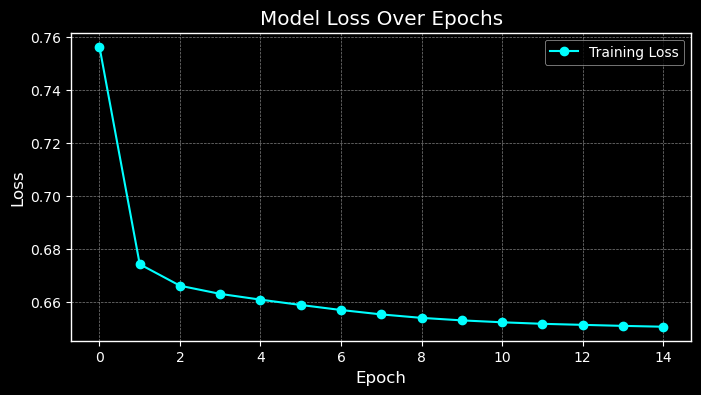

In [62]:
import matplotlib.pyplot as plt

# Set dark theme
plt.style.use('dark_background')

# Set figure size (width, height) in inches
plt.figure(figsize=(8, 4))

# Assuming history is the variable containing your training history
# and it has 'loss' key

# Plotting training loss values
plt.plot(history.history['loss'], label='Training Loss', color='cyan', linestyle='-', marker='o')


# Adding grid lines
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Adding title and labels
plt.title('Model Loss Over Epochs', color='white')
plt.ylabel('Loss', color='white')
plt.xlabel('Epoch', color='white')

# Adding legend
plt.legend(loc='upper right')

# Optionally, adjust axis limits
# plt.ylim([0, max(max(history.history['loss']), max(history.history.get('val_loss', [0])))])
# plt.xlim([0, len(history.history['loss']) - 1])

# Optionally, add annotations
# if 'val_loss' in history.history:
#     plt.annotate('Lowest Validation Loss', xy=(epoch, val_loss), xytext=(epoch + 1, val_loss + 0.1),
#                  arrowprops=dict(facecolor='white', shrink=0.05))

# Display the plot
plt.show()


## **Testing the Model**

First let's create functions that enable the mapping of movie IDs to titles and vice versa, as well as the mapping between movie IDs and unique movie IDs within the dataset.

In [36]:
data_np = data.to_numpy()

# Function to map movie ID to its title
def movieId_to_title(id):
  for row in data_np:
    if row[0] == id:
      return row[1]
  return None

# Function to map unique movie ID to its title
def unique_movieId_to_title(uid):
  for row in data_np:
    if row[6] == uid:
      return row[1]
  return None

# Function to map movie ID to unique movie ID
def movieId_to_unique_movieId(id):
  for row in data_np:
    if row[0] == id:
      return int(row[6])
  return None

# Function to map unique movie ID to movie ID
def unique_movieId_to_movieId(uid):
  for row in data_np:
    if row[6] == uid:
      return row[0]
  return None

In [37]:
#Inspecting and analysing the weights of the embedding layer in the model
movie_layer = model.get_layer('movies_embeddings')
movie_weights = movie_layer.get_weights()[0]
print(movie_weights.shape)
print(movie_weights[0])

(1830, 50)
[-4.2447289e-03  4.3359809e-02  2.7869511e-01  4.3374185e-02
 -3.6715511e-02 -4.1005015e-02 -3.1298906e-01 -1.1233622e-02
 -4.7610000e-02 -3.3727471e-02 -5.1208204e-01 -6.2618978e-02
  1.7249051e-02 -7.8591574e-03 -1.3589116e-02  2.4490304e-01
 -2.9833820e-01  1.4817819e-02  1.4420934e-02 -3.7597001e-01
 -1.9827514e-04  2.6543546e-01  6.5105264e-03  1.4648241e-01
 -3.2993567e-01 -3.4248356e-02 -4.4081789e-01  2.7722685e-02
  6.8555212e-01 -1.8171478e-02 -1.0733800e-02 -1.7037845e-01
 -1.0557895e-02 -2.1218689e-01  1.1102890e-01  1.2701865e-01
  1.4635669e-01  2.7888006e-01 -4.4462919e-01  3.5919365e-01
  5.5783175e-02  1.3719772e-02  1.5789939e-01  8.1225902e-02
 -5.8398370e-02 -1.4328257e-02  1.8189145e-02  7.4576087e-02
 -9.0796184e-03  1.5540877e-01]


In [38]:
#Normalising the weights of the embedding layer associated with the movies
movie_weights_normalized = movie_weights/np.linalg.norm(movie_weights, axis=1, keepdims=True)
print(movie_weights_normalized[0])
np.sum(np.square(movie_weights_normalized[0]))

[-2.85658194e-03  2.91799176e-02  1.87553883e-01  2.91895922e-02
 -2.47084945e-02 -2.75952090e-02 -2.10632727e-01 -7.55990809e-03
 -3.20401751e-02 -2.26976294e-02 -3.44616652e-01 -4.21407931e-02
  1.16081210e-02 -5.28898928e-03 -9.14508849e-03  1.64812788e-01
 -2.00773120e-01  9.97197069e-03  9.70487855e-03 -2.53017128e-01
 -1.33433525e-04  1.78630516e-01  4.38139914e-03  9.85784978e-02
 -2.22037315e-01 -2.30481699e-02 -2.96657920e-01  1.86565779e-02
  4.61357087e-01 -1.22288875e-02 -7.22354231e-03 -1.14659846e-01
 -7.10516283e-03 -1.42795742e-01  7.47192949e-02  8.54799375e-02
  9.84938890e-02  1.87678352e-01 -2.99222797e-01  2.41727114e-01
  3.75404917e-02  9.23301652e-03  1.06261805e-01  5.46627231e-02
 -3.93004417e-02 -9.64250974e-03  1.22407777e-02  5.01875840e-02
 -6.11032499e-03  1.04585685e-01]


1.0

In [40]:
# Movie recommend function
def movie_recommend(movieId, weights, n=10):
  # Get the movie title from movie ID
  title = movieId_to_title(movieId)
  if not title:
      print("Movie ID not found!")
      return

  print('Printing recommendations for:', title, '\n\n')

  # Get the unique movie ID from the movie ID
  uid = movieId_to_unique_movieId(movieId)
  if uid is None:
      print("Unique Movie ID not found!")
      return

  # Calculate similarity using dot product
  # similarity = np.dot(weights, weights[uid].reshape(-1, 1)).flatten()
  similarity = np.dot(weights, weights[uid])

  # Sort similarities and get the closest movies
  sorted_sim = np.argsort(similarity)
  closest = sorted_sim[-n-1:-1]

  # Print top n recommendation
  count = 0
  for i in reversed(closest):
      count += 1
      # print(f'{count:{2}}: {unique_movieId_to_title(i):80} ---> Similarity: {similarity[i]:.2}')
      movie_title = unique_movieId_to_title(i)
      if movie_title:
        print(f'{count:{2}}: {movie_title:80}  Similarity: {similarity[i]:.2f}')
      else:
        print(f'{count:{2}}: Movie ID {i:80} Similarity: {similarity[i]:.2f}')

In [41]:
#An instance of a movie recommending
movie_recommend(5, movie_weights_normalized);

Printing recommendations for: Father of the Bride Part II (1995) 


 1: Ace Ventura: When Nature Calls (1995)                                             Similarity: 0.80
 2: Jumanji (1995)                                                                    Similarity: 0.79
 3: Toy Story (1995)                                                                  Similarity: 0.78
 4: Heat (1995)                                                                       Similarity: 0.75
 5: GoldenEye (1995)                                                                  Similarity: 0.75
 6: Copycat (1995)                                                                    Similarity: 0.75
 7: Seven (a.k.a. Se7en) (1995)                                                       Similarity: 0.74
 8: Braveheart (1995)                                                                 Similarity: 0.73
 9: Toy Story (1995)                                                                  Similarity: 0.73
10: S

In [42]:
movie_recommend(3000, movie_weights_normalized)

Printing recommendations for: Princess Mononoke (Mononoke-hime) (1997) 


 1: Jumanji (1995)                                                                    Similarity: 0.89
 2: Toy Story (1995)                                                                  Similarity: 0.88
 3: Heat (1995)                                                                       Similarity: 0.83
 4: Sense and Sensibility (1995)                                                      Similarity: 0.82
 5: Babe (1995)                                                                       Similarity: 0.78
 6: Toy Story (1995)                                                                  Similarity: 0.77
 7: Ace Ventura: When Nature Calls (1995)                                             Similarity: 0.77
 8: Toy Story (1995)                                                                  Similarity: 0.77
 9: Toy Story (1995)                                                                  Similarity: 0.76

In [43]:
movie_recommend(4896, movie_weights_normalized);

Printing recommendations for: Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) 


 1: Toy Story (1995)                                                                  Similarity: 0.80
 2: Usual Suspects, The (1995)                                                        Similarity: 0.75
 3: Toy Story (1995)                                                                  Similarity: 0.74
 4: Sense and Sensibility (1995)                                                      Similarity: 0.74
 5: Indian in the Cupboard, The (1995)                                                Similarity: 0.74
 6: Toy Story (1995)                                                                  Similarity: 0.73
 7: GoldenEye (1995)                                                                  Similarity: 0.73
 8: Apollo 13 (1995)                                                                  Similarity: 0.71
 9: Toy Story (1995)                            

In [44]:
movie_recommend(18, movie_weights_normalized);

Printing recommendations for: Four Rooms (1995) 


 1: Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                                         Similarity: 0.87
 2: Heat (1995)                                                                       Similarity: 0.84
 3: Get Shorty (1995)                                                                 Similarity: 0.83
 4: Toy Story (1995)                                                                  Similarity: 0.82
 5: Toy Story (1995)                                                                  Similarity: 0.76
 6: Batman Forever (1995)                                                             Similarity: 0.75
 7: Toy Story (1995)                                                                  Similarity: 0.72
 8: Toy Story (1995)                                                                  Similarity: 0.72
 9: Grumpier Old Men (1995)                                                           Similarity: 0.70
10: Toy Story (1995)  

### **Multi-input movie recommendation model**

_Developing a movie recommendation prediction where the input is more than one and therefore recommendation is needed._

In [45]:
def movie_recommend_multiInput(movieIds, weights, n=10):
    recs = []
    for movieId in movieIds:
        uid = movieId_to_unique_movieId(movieId)
        if uid is None:
            print(f"Movie ID {movieId} not found!")
            continue

        similarity = np.dot(weights, weights[uid])
        sorted_sim = np.argsort(similarity)
        closest = sorted_sim[-n-1:-1]

        for i in reversed(closest):
            recs.append({"Movie_Name": unique_movieId_to_title(i), "Similarity": similarity[i]})

    # Sort combined recommendations by similarity in descending order
    combined_recs_sorted = sorted(recs, key=lambda i: i['Similarity'], reverse=True)

    # Remove duplicate recommendations
    seen = set()
    unique_recs = []
    for rec in combined_recs_sorted:
        if rec["Movie_Name"] not in seen:
            unique_recs.append(rec)
            seen.add(rec["Movie_Name"])
            if len(unique_recs) == n:
                break

    # Print the top `n` recommendations
    for i, rec in enumerate(unique_recs, start=1):
        print(f"{i:{2}}: {rec['Movie_Name']} ---> Similarity: {rec['Similarity']:.2f}")

In [46]:
# Determining the recommendation for 2 movie inputs wiht an nstance of movie ID not found
movie_recommend_multiInput([10,8756], movie_weights_normalized)

Movie ID 8756 not found!
 1: Hackers (1995) ---> Similarity: 0.86
 2: Postman, The (Postino, Il) (1994) ---> Similarity: 0.85
 3: Toy Story (1995) ---> Similarity: 0.85
 4: Powder (1995) ---> Similarity: 0.80
 5: Father of the Bride Part II (1995) ---> Similarity: 0.79
 6: Happy Gilmore (1996) ---> Similarity: 0.79
 7: Ace Ventura: When Nature Calls (1995) ---> Similarity: 0.79
 8: Blade Runner (1982) ---> Similarity: 0.79


In [47]:
movie_recommend_multiInput([4896, 2000], movie_weights_normalized)

 1: American President, The (1995) ---> Similarity: 0.84
 2: Toy Story (1995) ---> Similarity: 0.81
 3: Grumpier Old Men (1995) ---> Similarity: 0.80
 4: Shawshank Redemption, The (1994) ---> Similarity: 0.80
 5: GoldenEye (1995) ---> Similarity: 0.77
 6: Usual Suspects, The (1995) ---> Similarity: 0.75
 7: To Die For (1995) ---> Similarity: 0.74
 8: Sense and Sensibility (1995) ---> Similarity: 0.74
 9: Indian in the Cupboard, The (1995) ---> Similarity: 0.74
10: Apollo 13 (1995) ---> Similarity: 0.71


In [48]:
movie_recommend_multiInput([48, 245], movie_weights_normalized)

Movie ID 245 not found!
 1: American President, The (1995) ---> Similarity: 0.84
 2: Toy Story (1995) ---> Similarity: 0.81
 3: Grumpier Old Men (1995) ---> Similarity: 0.80
 4: Shawshank Redemption, The (1994) ---> Similarity: 0.80
 5: GoldenEye (1995) ---> Similarity: 0.77
 6: To Die For (1995) ---> Similarity: 0.74
 7: Leaving Las Vegas (1995) ---> Similarity: 0.70


In [49]:
movie_recommend_multiInput([552, 2065, 2], movie_weights_normalized)

 1: Jumanji (1995) ---> Similarity: 0.89
 2: Before Sunrise (1995) ---> Similarity: 0.87
 3: Toy Story (1995) ---> Similarity: 0.86
 4: Pulp Fiction (1994) ---> Similarity: 0.86
 5: Usual Suspects, The (1995) ---> Similarity: 0.85
 6: Heat (1995) ---> Similarity: 0.85
 7: American President, The (1995) ---> Similarity: 0.84
 8: Powder (1995) ---> Similarity: 0.83
 9: Grumpier Old Men (1995) ---> Similarity: 0.83
10: Braveheart (1995) ---> Similarity: 0.81


## **Embeddings Visualisation of the Movies**

(1830, 2)


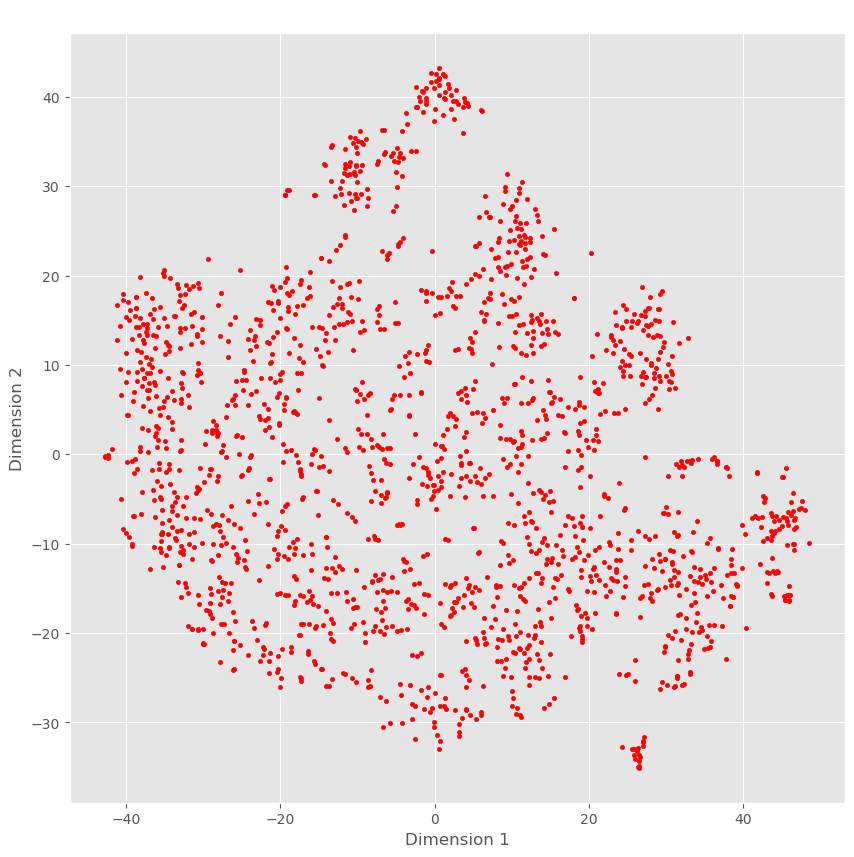

In [50]:
InteractiveShell.ast_node_interactivity = 'all'

# Reduce dimensions of embeddings
def reduce_dim(weights, components):
    return TSNE(n_components=components, metric='cosine').fit_transform(weights)

movie_r = reduce_dim(movie_weights_normalized, components=2)
print(movie_r.shape)

# Plot the reduced dimensions
plt.figure(figsize=(10, 10))
plt.scatter(movie_r[:, 0], movie_r[:, 1], c='r', marker='.')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title("Movie Embeddings Visualised")
plt.show();


 The dataset is processed to extract and map movie genres, ensuring that each movie is associated with a specific genre based on a predefined set of genres. The resulting list contains the selected genres for each movie.

In [51]:
import random
genres_list = data.loc[:,["UniqueMovieId","genres"]]
genres_list = genres_list.drop_duplicates()

print(genres_list)
genre_index = []

def get_gen(gens):
  gen_to_include = ['comedy', 'drama', 'action', 'romance', 'sci-fi', 'horror', 'children']
  for i in gens:
    if i in gen_to_include:
      return i
    else:
      return gens[0]
for i in genres_list.iloc:
  gens = i[1]
  gens = list(gens.split('|'))
  genre_index.append({i[0]: get_gen(gens).lower()})
  #print(genre_index[:10])
print(genre_index[-10:])

genres = []

for i in genre_index:
  # if list(i.values())[0] not in set(genres):
  g = list(i.values())
  genres.append(g[0])
# print(genres)

          UniqueMovieId                                       genres
0                     0  Adventure|Animation|Children|Comedy|Fantasy
57309                 1                   Adventure|Children|Fantasy
81537                 2                               Comedy|Romance
93341                 3                                       Comedy
105055                4                        Action|Crime|Thriller
...                 ...                                          ...
18710903           1825                                  Crime|Drama
18714613           1826                 Adventure|Animation|Children
18718432           1827              Action|Adventure|Fantasy|Sci-Fi
18721739           1828                         Action|Comedy|Sci-Fi
18725988           1829            Action|Adventure|Animation|Sci-Fi

[1830 rows x 2 columns]
[{1820: 'horror'}, {1821: 'action'}, {1822: 'action'}, {1823: 'action'}, {1824: 'sci-fi'}, {1825: 'crime'}, {1826: 'adventure'}, {1827: 'action'}, 

C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_28616\985694195.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gens = i[1]
C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_28616\985694195.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genre_index.append({i[0]: get_gen(gens).lower()})


In [52]:
from collections import Counter, OrderedDict
def count_items(l):
    counts = Counter(l)
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    return counts

# Remove genres not found
genre_counts = count_items(genres)
list(genre_counts.items())[:10]

[('action', 555),
 ('comedy', 439),
 ('drama', 351),
 ('adventure', 186),
 ('crime', 119),
 ('animation', 46),
 ('horror', 40),
 ('children', 35),
 ('thriller', 14),
 ('mystery', 12)]

_Plotting the movie embeddings with the 10 most popular genres._

1797


C:\Users\svijayaraghavan\AppData\Local\Temp\ipykernel_28616\1234349215.py:15: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ints, gen = pd.factorize(genres)


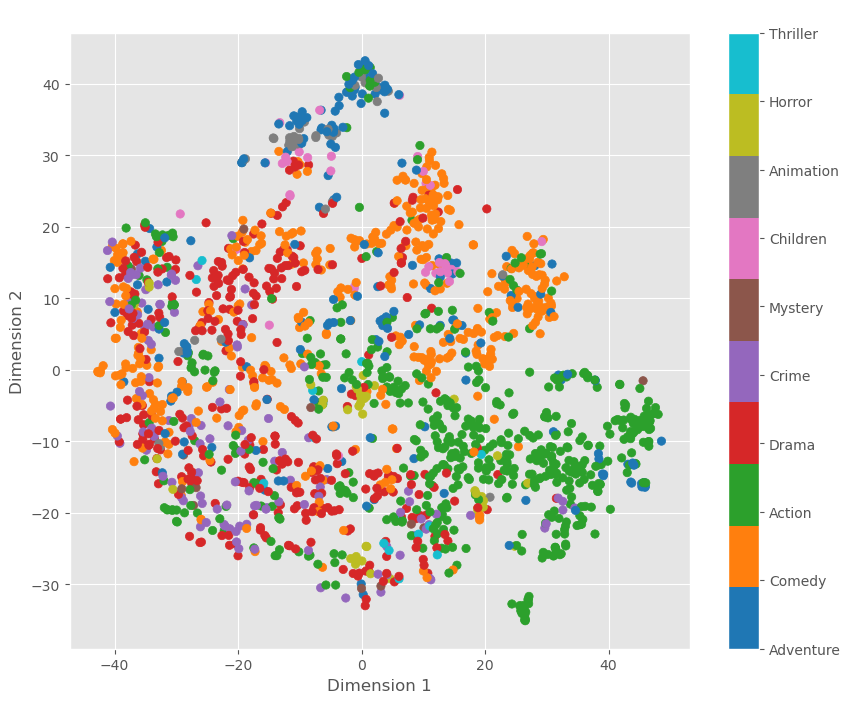

In [53]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

idx_include = []
genres = []

for i in genre_index:
    if list(i.values())[0] in genre_to_include:
            idx_include.append(int(list(i.keys())[0]))
            genres.append(list(i.values())[0].capitalize())

print(len(idx_include))

# Factorizing genres to convert them into integer labels
ints, gen = pd.factorize(genres)
gen[:5]

# Plotting
plt.figure(figsize = (10, 8))

sc = plt.scatter(movie_r[idx_include, 0], movie_r[idx_include, 1],
            c = ints, cmap = plt.cm.tab10)

cbar = plt.colorbar(sc)
cbar.set_ticks(np.arange(len(gen)))
cbar.set_ticklabels(gen)
cbar.ax.set_title('Genre', loc='left')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of Movie Embeddings')
plt.show();
# print(gen)
# for j, lab in enumerate(gen):
#     cbar.ax.text(1, (2 * j + 1) / ((2.3) ), lab, ha='left', va='center')
# cbar.ax.set_title('Genre', loc = 'left')

# plt.xlabel('1'); plt.ylabel('2'); plt.title('Visualization of MOVIE Embeddings');